# RNN

- Will create a simple vanilla RNN in Pytorch without using nn.RNN.</br> 
- The Mackey Glass time series dataset will be used, it contains a single time series input. 
</br></br>

### Import Data and Libraries
---

In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [248]:
data = torch.tensor(pd.read_csv("data.txt", header=None).values)
data.shape

torch.Size([10000, 1])

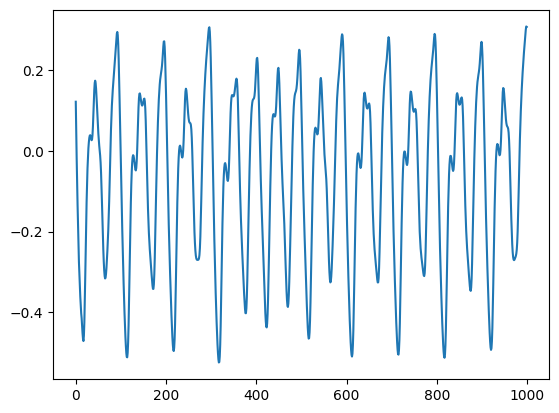

In [249]:
# plots the first 1000 points in the dataset
plt.plot(data[:1000])

In [250]:
CONTEXT_LENGTH = 8
EPOCHS = 20
LEARNING_RATE = 3e-4
BATCH_SIZE = 16
HIDDEN_SIZE = 32

</br></br>

### Basic Data Preprocessing
---

</bR>

Now will turn the dataset into windows of length 8. These length 8 windows will be used to predict the next '9th' element in the sequence. There will be a window for each index in the dataset, ex: `(data[0]--data[8], data[1]--data[9], data[n - 8]--data[n])`

In [251]:
# Create all the windows for each starting index, each window is a vector of length 8
arr = [data[i:i+CONTEXT_LENGTH] for i in range(len(data) - CONTEXT_LENGTH)]

# horizontally stack each vector and transpose: n x 8
x = torch.hstack(arr).transpose(0, 1)

# offset the y by context length to serve as the 9th target element for each window
y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)

C:\Users\adika\AppData\Local\Temp\ipykernel_9376\2385428353.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)


In [252]:
print(x.shape, y.shape)
print(f"\nSequence {list(x[0].numpy())} \nPredicts: {y[0].item()}")

torch.Size([9992, 8]) torch.Size([9992, 1])

Sequence [0.1220639965678425, 0.0471968158986172, -0.018330350400856732, -0.08194957982526882, -0.13422157698005047, -0.18542675204413897, -0.22934343063213447, -0.27547468871792924] 
Predicts: -0.3057978195680628


</br>

Make an 80/20 train test split.

In [253]:
size = int(0.8 * x.shape[0])
X_train = x[:size]
y_train = y[:size]
X_test = x[size:]
y_test = y[size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([7993, 8]),
 torch.Size([7993, 1]),
 torch.Size([1999, 8]),
 torch.Size([1999, 1]))

</br>

`TimeSeriesDataset` will load in the train and test splits and store the respective x and y. It will have a len and getitem function that return the length and the value at an index respectively. Because it inherits from pytorch's Dataset object, it is used to pass into DataLoader which converts the data into batches of size BATCH_SIZE and shuffles the data.

In [254]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [255]:
train_dataset = DataLoader(TimeSeriesDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
test_dataset  = DataLoader(TimeSeriesDataset(X_test, y_test),   BATCH_SIZE, shuffle=True)

In [256]:
print("Train Data Shape: (N, BATCH_SIZE, CONTEXT_SIZE)")

Train Data Shape: (N, BATCH_SIZE, CONTEXT_SIZE)


</br></br>

### Create RNN 
---

</br>

Now will actually create the RNN.

`RNNCell`
- $W_{ih}$: Weights used on the input at a particular timestep. Projects the input from input dimension to hidden dimension
- $W_{hh}$: Weights used in the hidden state of the cell. Hidden state is how memory of previous inputs from previous timesteps is preserved. The input at each timestep is factored in with the weighted aggregated of all previous inputs at all preivous timesteps. 
- Computes the next hidden state $h_t$ based on the formula: $h_t = tanh(W_{ih}^Tx_t + b_{ih} + W_{hh}^Th_{t-1} + b_{hh})$

</br>

`RNN`
- Takes an input of shape (BATCH_SIZE X CONTEXT_LENGTH)
- Hidden states are initialized to 0's 
- For each timestep, the column of the input corresponding to the t'th input in each batch is sent to the RNN cell to compute the $h_t$ for the current timestep, to be used in the calculations for the next timestep
- All hidden states for each timestep are collected, the final timestep hidden state is used to calculate output using an output linear layer

In [257]:
class RNNCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.Wxh = nn.Linear(in_dim, hidden_dim)
        self.Whh = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, xt, ht):
        xh = self.Wxh(xt)
        hidden_state = self.Whh(ht)
        hidden_state = F.tanh(hidden_state + xh)
        return hidden_state


class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell = RNNCell(in_dim, hidden_dim)
        self.out_lin = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        h_t_minus_1 = torch.zeros((1, HIDDEN_SIZE))
        h_t = torch.zeros((1, HIDDEN_SIZE))
        res = []
        for t in range(x.shape[1]):
            h_t = self.cell(x[:,t].view(-1, 1), h_t_minus_1)
            res.append(h_t)
            h_t_minus_1 = h_t

        res = torch.stack(res)
        
        final_out = res[-1]
        output = self.out_lin(final_out)
        return output

</br></br>

### Train RNN
---
</br>

Will now train this RNN for 20 epochs. Since this is a time series prediction task, MSE Loss will be used as the loss function.

In [258]:
def train_epoch(model, optim):
    lossi = []
    for x, y in train_dataset:
        # Forward Pass
        output = model(x.float())
        loss = F.mse_loss(output, y.float())

        # Backward Pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Track stats
        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean().item()


@torch.no_grad()
def val_epoch(model):
    lossi = []
    for x, y in test_dataset:
        # Forward pass and track loss
        output = model(x.float())
        loss = F.mse_loss(output, y.float())
        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean().item()

In [259]:
model = RNN(1, HIDDEN_SIZE)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

for name, i in model.named_parameters():
    print(name, ": ", i.shape, i.grad)

cell.Wxh.weight :  torch.Size([32, 1]) None
cell.Wxh.bias :  torch.Size([32]) None
cell.Whh.weight :  torch.Size([32, 32]) None
cell.Whh.bias :  torch.Size([32]) None
out_lin.weight :  torch.Size([1, 32]) None
out_lin.bias :  torch.Size([1]) None


In [260]:
train_lossi = []
test_lossi = []
for epoch in range(EPOCHS):
  train_loss = train_epoch(model, optim)
  test_loss = val_epoch(model)

  train_lossi.append(train_loss)
  test_lossi.append(test_loss)

  print(f"EPOCH: {epoch} |  TRAIN-LOSS: {round(train_loss, 6)} |  VAL-LOSS: {round(test_loss, 6)}")

EPOCH: 0 |  TRAIN-LOSS: 0.004215 |  VAL-LOSS: 0.000357
EPOCH: 1 |  TRAIN-LOSS: 0.000284 |  VAL-LOSS: 0.000214
EPOCH: 2 |  TRAIN-LOSS: 0.000176 |  VAL-LOSS: 0.000145
EPOCH: 3 |  TRAIN-LOSS: 0.000136 |  VAL-LOSS: 0.000115
EPOCH: 4 |  TRAIN-LOSS: 0.000101 |  VAL-LOSS: 7.6e-05
EPOCH: 5 |  TRAIN-LOSS: 7.2e-05 |  VAL-LOSS: 5.5e-05
EPOCH: 6 |  TRAIN-LOSS: 4.9e-05 |  VAL-LOSS: 3.1e-05
EPOCH: 7 |  TRAIN-LOSS: 3.1e-05 |  VAL-LOSS: 2.3e-05
EPOCH: 8 |  TRAIN-LOSS: 3e-05 |  VAL-LOSS: 3.8e-05
EPOCH: 9 |  TRAIN-LOSS: 2.7e-05 |  VAL-LOSS: 2e-05
EPOCH: 10 |  TRAIN-LOSS: 2.5e-05 |  VAL-LOSS: 2.1e-05
EPOCH: 11 |  TRAIN-LOSS: 2.6e-05 |  VAL-LOSS: 2e-05
EPOCH: 12 |  TRAIN-LOSS: 2.4e-05 |  VAL-LOSS: 1.7e-05
EPOCH: 13 |  TRAIN-LOSS: 2.3e-05 |  VAL-LOSS: 2.2e-05
EPOCH: 14 |  TRAIN-LOSS: 2e-05 |  VAL-LOSS: 2e-05
EPOCH: 15 |  TRAIN-LOSS: 2.3e-05 |  VAL-LOSS: 1.5e-05
EPOCH: 16 |  TRAIN-LOSS: 1.9e-05 |  VAL-LOSS: 1.4e-05
EPOCH: 17 |  TRAIN-LOSS: 1.8e-05 |  VAL-LOSS: 1.3e-05
EPOCH: 18 |  TRAIN-LOSS: 1.6e-05 |  VAL

</br></br>

### Evaluate RNN 
---

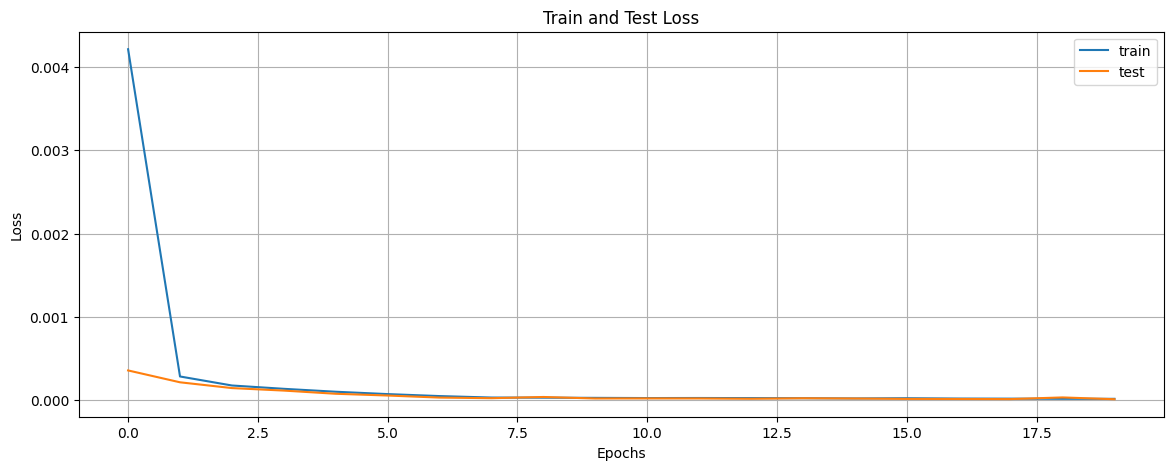

In [262]:
plt.figure(figsize=(14, 5))

sns.lineplot(train_lossi, label='train')
sns.lineplot(test_lossi, label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.grid(True)

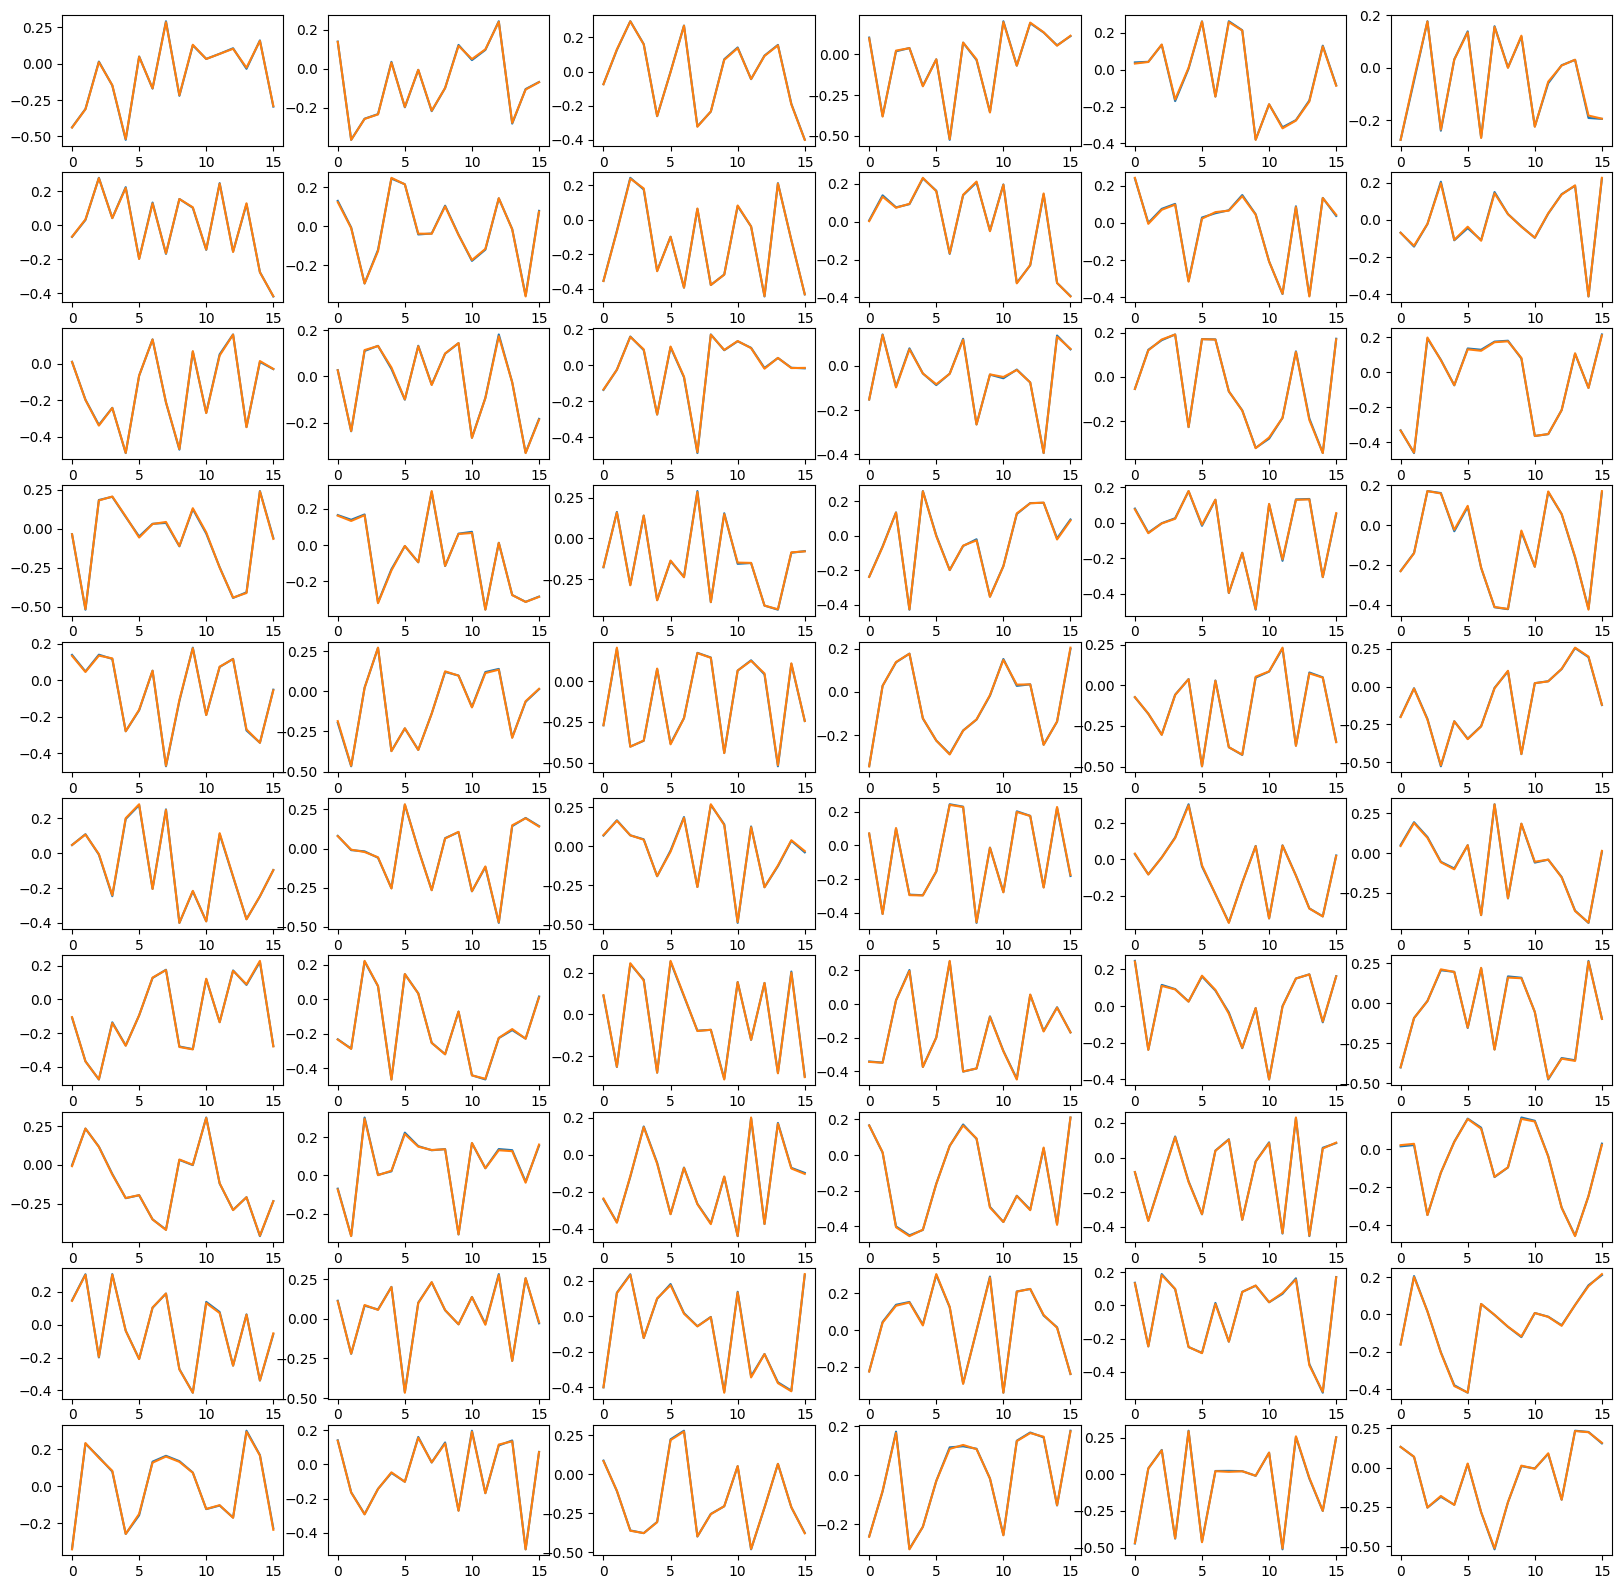

In [263]:
c = 0
plt.figure(figsize=(20, 20))
for i in test_dataset:
    x, y = i
    output = model(x.float())
    c += 1
    plt.subplot(10, 6, c)
    plt.plot(y.detach().numpy())
    plt.plot(output.detach().numpy())
    if c == 60:
        break